# AdventureWorks SQL Project
Filip Östlund

Installerar och importar det som behövs. Skapar sedan en engine kopplat till databasen AdventureWorks2022
_____________________________________________________________________________________________________________________________

In [23]:
!pip install sqlalchemy
!pip install pyodbc

In [16]:
from sqlalchemy import create_engine, Table, inspect
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Windows authentication
 
Server = 'FILIPS_HP'
Database = 'AdventureWorks2022'
Driver = 'ODBC Driver 17 for SQL Server'
Database_Con = f'mssql://@{Server}/{Database}?driver={Driver}'
 
engine = create_engine(Database_Con)
connection = engine.connect()

# 1

Querys till sammanfattningen

_____________________________________________________________________________________________________________________________

In [5]:
# Försäljnningsdata för att se hur det gått för företaget

SalesNumbers = """WITH ProductIDandCost AS
(
SELECT
    YEAR(C.OrderDate) AS SalesYear,
    ROUND(CAST(SUM(A.OrderQty * B.StandardCost)/1000000 AS FLOAT),2) AS TotalProductCostInMillions
FROM Sales.SalesOrderDetail AS A
INNER JOIN Production.Product AS B 
    ON A.ProductID = B.ProductID
INNER JOIN Sales.SalesOrderHeader AS C
    ON A.SalesOrderID = C.SalesOrderID
GROUP BY YEAR(C.OrderDate)
)
,
GrossSales AS
(
SELECT
    YEAR(A.OrderDate) AS SalesYear,
    ROUND(CAST(SUM(B.LineTotal)/1000000 AS FLOAT),2) AS GrossSalesInMillions
FROM Sales.SalesOrderHeader AS A
INNER JOIN Sales.SalesOrderDetail AS B
    ON A.SalesOrderID = B.SalesOrderID
GROUP BY YEAR(A.OrderDate)
)
SELECT 
    A.SalesYear,
    B.GrossSalesInMillions,
    A.TotalProductCostInMillions,
    ROUND((B.GrossSalesInMillions - A.TotalProductCostInMillions),2) AS GrossProfitInMillions
FROM ProductIDandCost AS A
INNER JOIN GrossSales AS B
    ON A.SalesYear = B.SalesYear
GROUP BY A.SalesYear, B.GrossSalesInMillions, A.TotalProductCostInMillions
ORDER BY SalesYear;"""

df_SalesNumbers = pd.read_sql(sql=SalesNumbers, con=connection)
display(df_SalesNumbers)

,SalesYear,GrossSalesInMillions,TotalProductCostInMillions,GrossProfitInMillions
0,2011,12.64,11.01,1.63
1,2012,33.52,32.58,0.94
2,2013,43.62,40.27,3.35
3,2014,20.06,16.62,3.44


In [7]:
# Huvudkategorierna av produkterna och hur mycket som sålts

SalesPerCategory = """SELECT
    A.ProductCategoryID,
    E.Name AS ProductCategory,
    SUM(C.OrderQty) AS TotalQuantitySold,
    CONCAT(ROUND(CAST(SUM(C.LineTotal)/1000000 AS FLOAT),2),'M') AS TotalGrossSales
FROM
    Production.ProductSubcategory AS A
INNER JOIN Production.Product AS B 
    ON A.ProductSubcategoryID = B.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail AS C 
    ON B.ProductID = C.ProductID
INNER JOIN Sales.SalesOrderHeader AS D 
    ON C.SalesOrderID = D.SalesOrderID
INNER JOIN Production.ProductCategory AS E 
    ON E.ProductCategoryID = A.ProductCategoryID
WHERE YEAR(D.OrderDate) = 2013
GROUP BY A.ProductCategoryID, E.Name
ORDER BY A.ProductCategoryID;"""

df_SalesPerCategory = pd.read_sql(sql=SalesPerCategory, con=connection)
display(df_SalesPerCategory)

,ProductCategoryID,ProductCategory,TotalQuantitySold,TotalGrossSales
0,1,Bikes,37748,36.27M
1,2,Components,24707,5.61M
2,3,Clothing,37180,1.07M
3,4,Accessories,32153,0.68M


In [8]:
# En mer detaljerad vy över vad företaget säljer + kostnad och listpris per produkt
OverviewOfSubCategorys = """SELECT
    B.ProductCategoryID,
    B.Name AS ProductSubCategory,
    COUNT(A.ProductID) AS ProductCount,
    AVG(A.StandardCost) AS AverageCostPerProduct,
    AVG(A.ListPrice) AS AverageListPricePerProduct
FROM Production.Product AS A
INNER JOIN Production.ProductSubcategory AS B 
    ON A.ProductSubcategoryID = B.ProductSubcategoryID
GROUP BY B.ProductCategoryID, B.Name
ORDER BY AverageCostPerProduct DESC;"""

df_OverviewOfSubCategorys = pd.read_sql(sql=OverviewOfSubCategorys, con=connection)
display(df_OverviewOfSubCategorys)

,ProductCategoryID,ProductSubCategory,ProductCount,AverageCostPerProduct,AverageListPricePerProduct
0,1,Road Bikes,43,993.5262,1597.4500
1,1,Mountain Bikes,32,933.7700,1683.3650
2,1,Touring Bikes,22,885.9342,1425.2481
3,2,Road Frames,33,480.3767,780.0436
4,2,Touring Frames,18,378.4704,631.4155
5,2,Mountain Frames,28,364.9359,678.2535
6,2,Cranksets,3,123.8716,278.9900
7,2,Wheels,14,98.0926,220.9292
8,2,Forks,3,81.8736,184.4000
9,4,Bike Stands,1,59.4660,159.0000


In [9]:
# Info från kundbasen. Om det är butik eller person, samt geografisk data
CustomerInfo = """
SELECT
    CustomerInfo,
    CustomerAmount
FROM
    (SELECT 
        COUNT(*) AS TotalCustomers,
        SUM(CASE WHEN (PersonID IS NOT NULL AND StoreID IS NULL) THEN 1 ELSE 0 END) AS PersonCustomers,
        SUM(CASE WHEN StoreID IS NOT NULL THEN 1 ELSE 0 END) AS StoreCustomers,
        SUM(CASE WHEN TerritoryID <= 6 THEN 1 ELSE 0 END) AS NorthAmericanCustomers,
        SUM(CASE WHEN TerritoryID <= 8 AND TerritoryID >= 7 OR TerritoryID = 10 THEN 1 ELSE 0 END) AS EuropeanCustomers,
        SUM(CASE WHEN TerritoryID = 9 THEN 1 ELSE 0 END) AS PacificCustomers
    FROM Sales.Customer) AS CustomerData
UNPIVOT (
    CustomerAmount FOR CustomerInfo IN 
        (TotalCustomers, PersonCustomers, StoreCustomers, NorthAmericanCustomers, EuropeanCustomers, PacificCustomers)) AS Unpivoted;"""

df_CustomerInfo = pd.read_sql(sql=CustomerInfo, con=connection)
display(df_CustomerInfo)

,CustomerInfo,CustomerAmount
0,TotalCustomers,19820
1,PersonCustomers,18484
2,StoreCustomers,1336
3,NorthAmericanCustomers,10428
4,EuropeanCustomers,5727
5,PacificCustomers,3665


In [10]:
# Överblick över de olika säljarna och deras prestationer
SalesPersonsTerritory = """SELECT 
    A.BusinessEntityID,
    C.FirstName,
    C.LastName,
    B.[Name] AS TerritoryName,
    B.[Group] AS TerritoryGroup,
    CONCAT(CONVERT(VARCHAR, ROUND(A.SalesYTD/1000000, 2)),'M') AS SalesYTD,
    CONCAT(CONVERT(VARCHAR, ROUND(A.SalesLastYear/1000000, 2)),'M') AS SalesLastYear
FROM Sales.SalesPerson AS A
INNER JOIN Sales.SalesTerritory AS B
    ON A.TerritoryID = B.TerritoryID
INNER JOIN Person.Person AS C
    ON A.BusinessEntityID = C.BusinessEntityID
ORDER BY A.SalesYTD DESC;"""

df_SalesPersonsTerritory = pd.read_sql(sql=SalesPersonsTerritory, con=connection)
display(df_SalesPersonsTerritory)

,BusinessEntityID,FirstName,LastName,TerritoryName,TerritoryGroup,SalesYTD,SalesLastYear
0,276,Linda,Mitchell,Southwest,North America,4.25M,1.44M
1,289,Jae,Pak,United Kingdom,Europe,4.12M,1.64M
2,275,Michael,Blythe,Northeast,North America,3.76M,1.75M
3,277,Jillian,Carson,Central,North America,3.19M,2.00M
4,290,Ranjit,Varkey Chudukatil,France,Europe,3.12M,2.40M
5,282,José,Saraiva,Canada,North America,2.60M,2.04M
6,281,Shu,Ito,Southwest,North America,2.46M,2.07M
7,279,Tsvi,Reiter,Southeast,North America,2.32M,1.85M
8,288,Rachel,Valdez,Germany,Europe,1.83M,1.31M
9,284,Tete,Mensa-Annan,Northwest,North America,1.58M,0.00M


In [11]:
# Antal anställda och könsfördelning
TotalEmployees = """SELECT
    COUNT(*) AS TotalEmployees,
    SUM(CASE WHEN Gender = 'F' THEN 1 ELSE 0 END) AS FemaleEmployees,
    SUM(CASE WHEN Gender = 'M' THEN 1 ELSE 0 END) AS MaleEmployees
FROM HumanResources.Employee;"""

df_TotalEmployees = pd.read_sql(sql=TotalEmployees, con=connection)
display(df_TotalEmployees)

,TotalEmployees,FemaleEmployees,MaleEmployees
0,290,84,206


In [105]:
# Vilka avdelningar som finns och hur många som jobbar på varje
EmployeeDepartments = """SELECT 
    C.Name AS DepartmentName,
    COUNT(A.BusinessEntityID) AS AmountOfEmployees
FROM HumanResources.Employee AS A
INNER JOIN HumanResources.EmployeeDepartmentHistory AS B
    ON A.BusinessEntityID = B.BusinessEntityID
INNER JOIN HumanResources.Department AS C 
    ON B.DepartmentID = C.DepartmentID
WHERE B.EndDate IS NULL
GROUP BY C.Name"""

df_EmployeeDepartments = pd.read_sql(sql=EmployeeDepartments, con=connection)
display(df_EmployeeDepartments)

,DepartmentName,AmountOfEmployees
0,Engineering,6
1,Tool Design,4
2,Sales,18
3,Marketing,9
4,Purchasing,12
5,Research and Development,4
6,Production,179
7,Production Control,6
8,Human Resources,6
9,Finance,10


In [89]:
# Skiftinformation per avdelning
ShiftsDepartments = """SELECT
    B.Name As DepartmentName,
    SUM(CASE WHEN A.ShiftID = 1 THEN 1 ELSE 0 END) AS DayShift,
    SUM(CASE WHEN A.ShiftID = 2 THEN 1 ELSE 0 END) AS EveningShift,
    SUM(CASE WHEN A.ShiftID = 3 THEN 1 ELSE 0 END) AS NightShift
FROM HumanResources.EmployeeDepartmentHistory AS A
INNER JOIN HumanResources.Department AS B
    ON A.DepartmentID = B.DepartmentID
WHERE A.EndDate IS NULL
GROUP BY B.Name"""

df_ShiftsDepartments = pd.read_sql(sql=ShiftsDepartments, con=connection)
display(df_ShiftsDepartments)

,DepartmentName,DayShift,EveningShift,NightShift
0,Engineering,6,0,0
1,Tool Design,4,0,0
2,Sales,18,0,0
3,Marketing,9,0,0
4,Purchasing,12,0,0
5,Research and Development,4,0,0
6,Production,79,54,46
7,Production Control,4,1,1
8,Human Resources,6,0,0
9,Finance,10,0,0


Plots till sammanfattningen, gjort om vissa querys för att ta ut en del av informationen som exempel till plots.

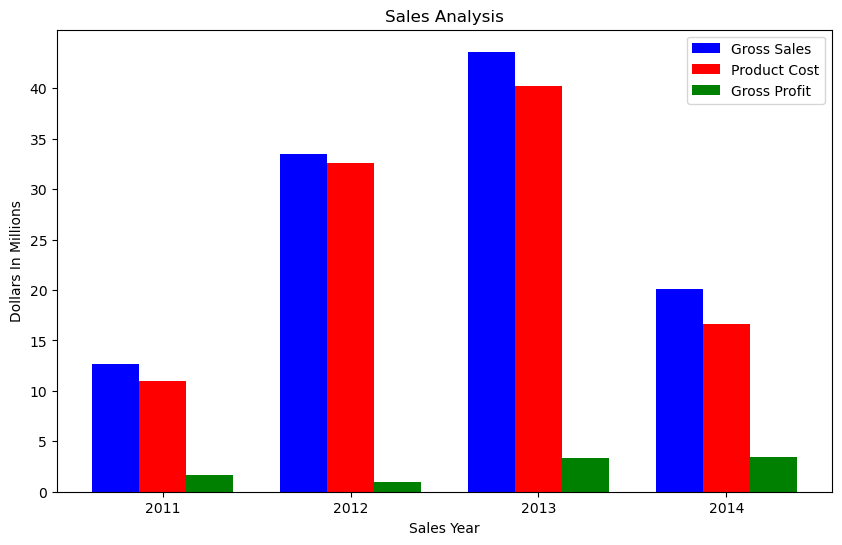

In [96]:
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
bar_positions = list(range(len(df_SalesNumbers['SalesYear'])))

ax.bar(bar_positions, df_SalesNumbers['GrossSalesInMillions'], width=bar_width, label='Gross Sales', color='blue')
ax.bar([pos + bar_width for pos in bar_positions], df_SalesNumbers['TotalProductCostInMillions'], width=bar_width, label='Product Cost', color = 'red')
ax.bar([pos + 2 * bar_width for pos in bar_positions], df_SalesNumbers['GrossProfitInMillions'], width=bar_width, label='Gross Profit', color = 'green')

ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(df_SalesNumbers['SalesYear'])
ax.set_yticks(range(0, 45, 5))
ax.set_xlabel('Sales Year')
ax.set_ylabel('Dollars In Millions')
ax.set_title('Sales Analysis')
ax.legend()

plt.show()

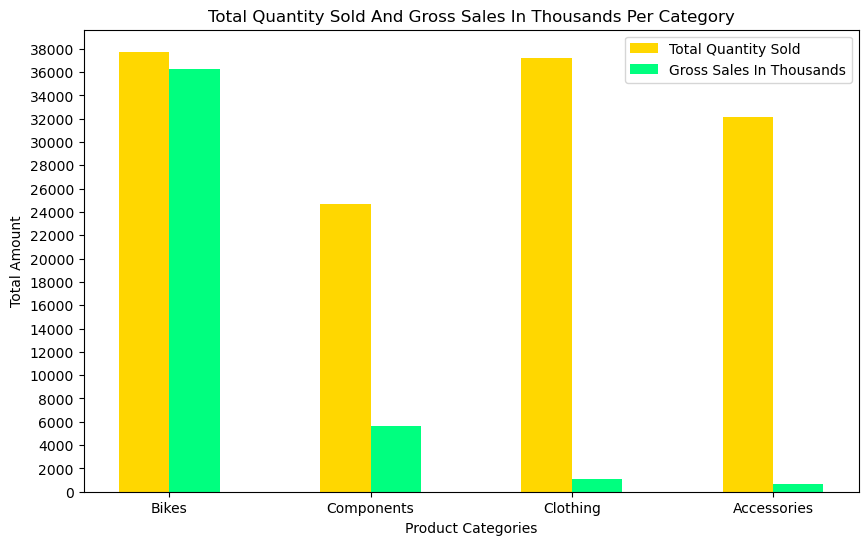

In [86]:
SalesPerCategoryPlot = """SELECT
    A.ProductCategoryID,
    E.Name AS ProductCategory,
    SUM(C.OrderQty) AS TotalQuantitySold,
    ROUND(CAST(SUM(C.LineTotal)/1000 AS FLOAT), 0) AS TotalGrossSales
FROM
    Production.ProductSubcategory AS A
INNER JOIN Production.Product AS B 
    ON A.ProductSubcategoryID = B.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail AS C 
    ON B.ProductID = C.ProductID
INNER JOIN Sales.SalesOrderHeader AS D 
    ON C.SalesOrderID = D.SalesOrderID
INNER JOIN Production.ProductCategory AS E 
    ON E.ProductCategoryID = A.ProductCategoryID
WHERE YEAR(D.OrderDate) = 2013
GROUP BY A.ProductCategoryID, E.Name
ORDER BY A.ProductCategoryID;"""

df_SalesPerCategoryPlot = pd.read_sql(sql=SalesPerCategoryPlot, con=connection)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
positions = np.arange(len(df_SalesPerCategoryPlot['ProductCategory']))

ax.bar(positions - bar_width/2, df_SalesPerCategoryPlot['TotalQuantitySold'], width=bar_width, label='Total Quantity Sold', color='gold')
ax.bar(positions + bar_width/2, df_SalesPerCategoryPlot['TotalGrossSales'], width=bar_width, label='Gross Sales In Thousands', color = 'springgreen')

ax.set_xticks(positions)
ax.set_xticklabels(df_SalesPerCategoryPlot['ProductCategory'])
ax.set_yticks(range(0, 40000, 2000))
ax.set_xlabel('Product Categories')
ax.set_ylabel('Total Amount')
ax.set_title('Total Quantity Sold And Gross Sales In Thousands Per Category')
ax.legend()

plt.show()

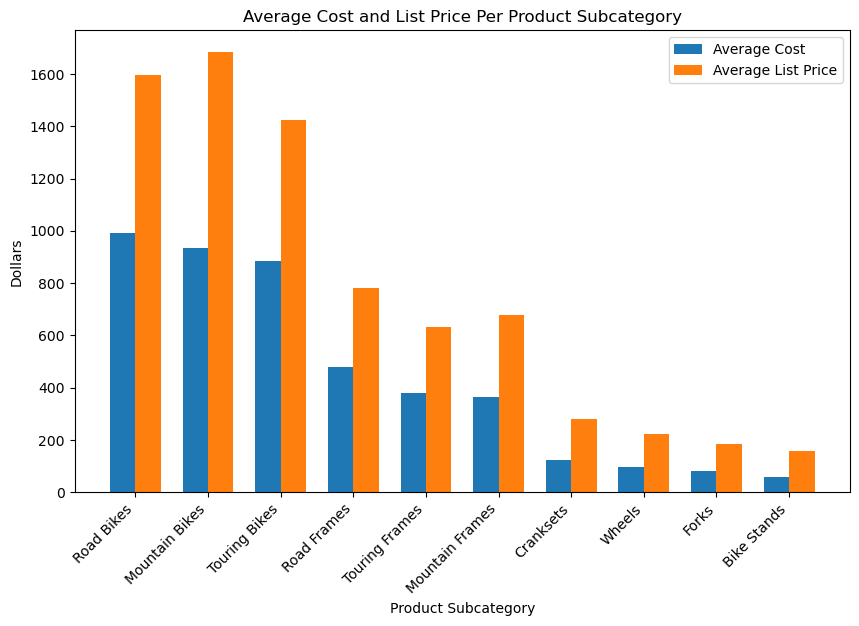

In [17]:
OverviewOfSubCategorysTop = """SELECT TOP (10)
    B.ProductCategoryID,
    B.Name AS ProductSubCategory,
    COUNT(A.ProductID) AS ProductCount,
    AVG(A.StandardCost) AS AverageCostPerProduct,
    AVG(A.ListPrice) AS AverageListPricePerProduct
FROM Production.Product AS A
INNER JOIN Production.ProductSubcategory AS B 
    ON A.ProductSubcategoryID = B.ProductSubcategoryID
GROUP BY B.ProductCategoryID, B.Name
ORDER BY AverageCostPerProduct DESC;"""

df_OverviewOfSubCategorysTop = pd.read_sql(sql=OverviewOfSubCategorysTop, con=connection)

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
positions = np.arange(len(df_OverviewOfSubCategorysTop['ProductSubCategory']))

ax.bar(positions - bar_width/2, df_OverviewOfSubCategorysTop['AverageCostPerProduct'], bar_width, label='Average Cost')
ax.bar(positions + bar_width/2, df_OverviewOfSubCategorysTop['AverageListPricePerProduct'], bar_width, label='Average List Price')

ax.set_xlabel('Product Subcategory')
ax.set_ylabel('Dollars')
ax.set_title('Average Cost and List Price Per Product Subcategory')
ax.set_xticks(positions)
ax.set_xticklabels(df_OverviewOfSubCategorysTop['ProductSubCategory'], rotation=45, ha='right')
ax.legend()

plt.show()

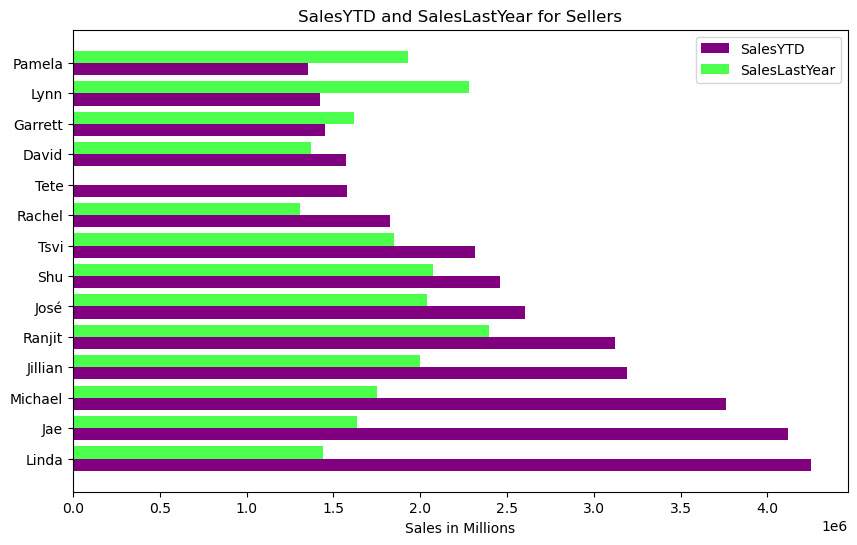

In [37]:
SalesPersonsTerritoryWithoutM = """
SELECT 
    A.BusinessEntityID,
    C.FirstName,
    C.LastName,
    B.[Name] AS TerritoryName,
    B.[Group] AS TerritoryGroup,
    ROUND(A.SalesYTD, 2) AS SalesYTD,
    ROUND(A.SalesLastYear, 2) AS SalesLastYear
FROM Sales.SalesPerson AS A
INNER JOIN Sales.SalesTerritory AS B
    ON A.TerritoryID = B.TerritoryID
INNER JOIN Person.Person AS C
    ON A.BusinessEntityID = C.BusinessEntityID
ORDER BY A.SalesYTD DESC;
"""

df_SalesPersonsTerritoryWithoutM = pd.read_sql(sql=SalesPersonsTerritoryWithoutM, con=connection)

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.4
positions = np.arange(len(df_SalesPersonsTerritoryWithoutM))

ax.barh(positions - bar_width/2, df_SalesPersonsTerritoryWithoutM['SalesYTD'], bar_width, label='SalesYTD', color='purple')

ax.barh(positions + bar_width/2, df_SalesPersonsTerritoryWithoutM['SalesLastYear'], bar_width, label='SalesLastYear', color='lime', alpha=0.7)

ax.set_yticks(positions)
ax.set_yticklabels(df_SalesPersonsTerritoryWithoutM['FirstName'])
ax.set_xlabel('Sales in Millions')
ax.set_title('SalesYTD and SalesLastYear for Sellers')
ax.legend()

plt.show()

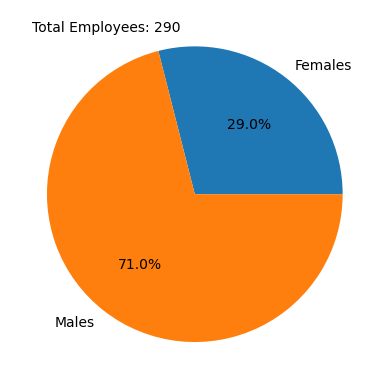

In [19]:
fig, ax = plt.subplots()

labels = ['Females', 'Males']
string = f"Total Employees: {df_TotalEmployees.loc[0, 'TotalEmployees']}"
female_proportion =  float(df_TotalEmployees['FemaleEmployees'] / df_TotalEmployees['TotalEmployees'])
male_proportion = float(df_TotalEmployees['MaleEmployees'] / df_TotalEmployees['TotalEmployees'])
sizes = [female_proportion, male_proportion]

ax.pie(sizes, labels = labels, autopct='%1.1f%%')
ax.text(-1.1, 1.1, string, fontsize=10)
plt.show()

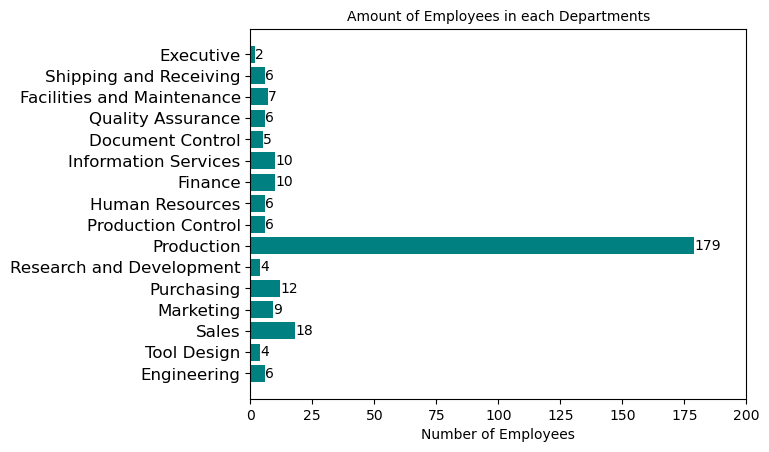

In [111]:
fig, ax= plt.subplots()

hbars = ax.barh(df_EmployeeDepartments['DepartmentName'], df_EmployeeDepartments['AmountOfEmployees'], color = 'teal')
ax.set_title('Amount of Employees in each Departments', fontsize = 10)
ax.set_xlabel('Number of Employees', fontsize = 10)
ax.set_yticks(range(len(df_EmployeeDepartments['DepartmentName'])))
ax.set_yticklabels(df_EmployeeDepartments['DepartmentName'], fontsize=12)
ax.bar_label(hbars)
ax.set_xlim(right=200)

plt.show()

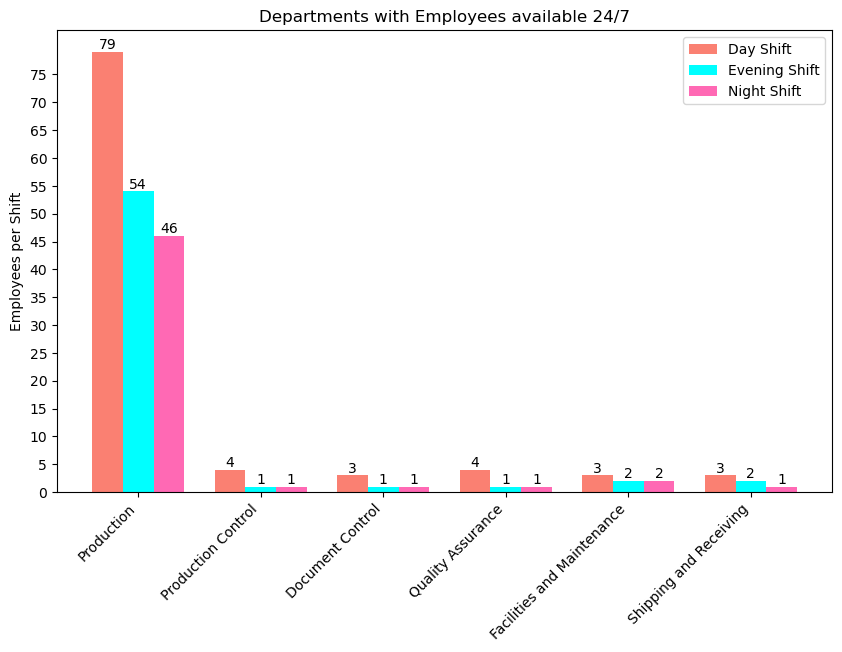

In [116]:
ShiftDepartmentsPlot = """WITH DepartmentShifts AS
(
SELECT
    B.Name As DepartmentName,
    SUM(CASE WHEN A.ShiftID = 1 THEN 1 ELSE 0 END) AS DayShift,
    SUM(CASE WHEN A.ShiftID = 2 THEN 1 ELSE 0 END) AS EveningShift,
    SUM(CASE WHEN A.ShiftID = 3 THEN 1 ELSE 0 END) AS NightShift
FROM HumanResources.EmployeeDepartmentHistory AS A
INNER JOIN HumanResources.Department AS B
    ON A.DepartmentID = B.DepartmentID
WHERE A.EndDate IS NULL
GROUP BY B.Name
)

SELECT 
    DepartmentName,
    DayShift,
    EveningShift,
    NightShift
FROM DepartmentShifts
WHERE EveningShift > 0 AND NightShift > 0"""

df_ShiftDepartmentsPlot = pd.read_sql(sql=ShiftDepartmentsPlot, con=connection)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
bar_positions = list(range(len(df_ShiftDepartmentsPlot['DepartmentName'])))

bar1=ax.bar(bar_positions, df_ShiftDepartmentsPlot['DayShift'], width=bar_width, label='Day Shift', color='salmon')
bar2=ax.bar([pos + bar_width for pos in bar_positions], df_ShiftDepartmentsPlot['EveningShift'], width=bar_width, label='Evening Shift', color = 'aqua')
bar3=ax.bar([pos + 2 * bar_width for pos in bar_positions], df_ShiftDepartmentsPlot['NightShift'], width=bar_width, label='Night Shift', color = 'hotpink')

ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(df_ShiftDepartmentsPlot['DepartmentName'], rotation=45, ha='right')
ax.set_yticks(range(0, 80, 5))
ax.set_ylabel('Employees per Shift')
ax.set_title('Departments with Employees available 24/7')
ax.bar_label(bar1)
ax.bar_label(bar2)
ax.bar_label(bar3)
ax.legend()

plt.show()

# 2

I min analys utgår jag från att databasen är ett stickprov från årtalen 2011-2014. Jag har fått i uppdrag att se om man under den tiden kunde se någon skillnad i mängd kasserade ordrar.

_____________________________________________________________________________________________________________________________

Queryn som jag använder mig av för att hämta de siffror som behövs för analysen:

In [38]:
ScrappedOrdersPerYear = """SELECT 
    YEAR(ModifiedDate) AS ScrapYear,
    COUNT(*) AS TotalWorkOrders,
    SUM(CASE WHEN ScrappedQty > 0 THEN 1 ELSE 0 END) AS ScrappedWorkOrders
FROM Production.WorkOrder
GROUP BY YEAR(ModifiedDate)
ORDER BY ScrapYear"""

df_ScrappedOrdersPerYear = pd.read_sql(sql=ScrappedOrdersPerYear, con=connection)
display(df_ScrappedOrdersPerYear)

,ScrapYear,TotalWorkOrders,ScrappedWorkOrders
0,2011,8328,64
1,2012,18545,172
2,2013,28264,298
3,2014,17454,195


Det första jag gör är att kolla på stickprovets olika år. 
Jag börjar med att räkna ut andelen kasserade produkter.
Därefter räknar jag ut "Margin Of Error" som är den statistiska felmarginalen.
Till sist skapar jag en undre och övre gräns för att man ska kunna se konfidensintervallet för varje år.

In [39]:
df_ScrappedOrdersPerYear['ProportionScrapped'] = df_ScrappedOrdersPerYear['ScrappedWorkOrders'] / df_ScrappedOrdersPerYear['TotalWorkOrders']

df_ScrappedOrdersPerYear['MarginOfError'] = 1.96 * np.sqrt((df_ScrappedOrdersPerYear['ProportionScrapped'] * (1 - df_ScrappedOrdersPerYear['ProportionScrapped'])) / df_ScrappedOrdersPerYear['TotalWorkOrders'])
df_ScrappedOrdersPerYear['LowerCI'] = df_ScrappedOrdersPerYear['ProportionScrapped'] - df_ScrappedOrdersPerYear['MarginOfError']
df_ScrappedOrdersPerYear['UpperCI'] = df_ScrappedOrdersPerYear['ProportionScrapped'] + df_ScrappedOrdersPerYear['MarginOfError']

display(df_ScrappedOrdersPerYear)

,ScrapYear,TotalWorkOrders,ScrappedWorkOrders,ProportionScrapped,MarginOfError,LowerCI,UpperCI
0,2011,8328,64,0.007685,0.001876,0.005809,0.009560
1,2012,18545,172,0.009275,0.001380,0.007895,0.010654
2,2013,28264,298,0.010543,0.001191,0.009353,0.011734
3,2014,17454,195,0.011172,0.001559,0.009613,0.012732


För att göra det enklare att få en uppfattning och kunna tolka resultatet på konfidensintervallen för de olika åren skapar jag här en plot. Ploten jag valde är en errorbar för jag tyckte den gav tydligast resultat.

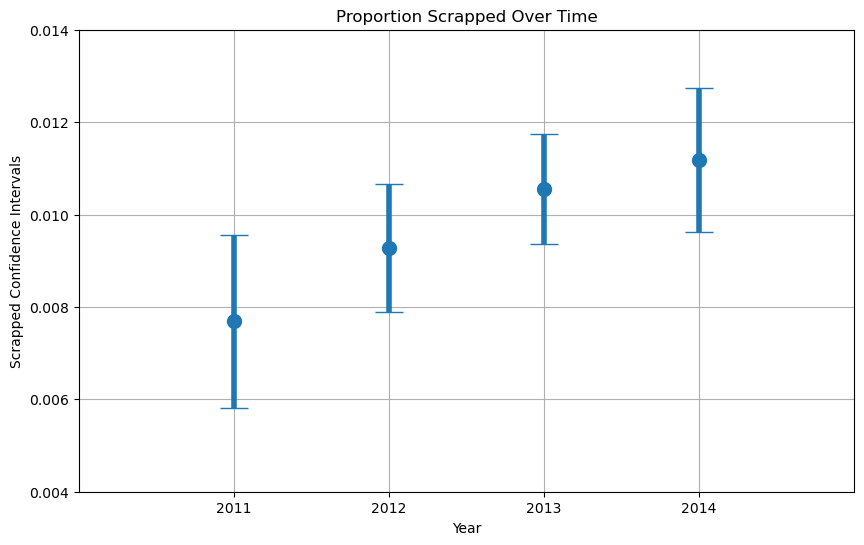

In [40]:
import matplotlib.pyplot as plt
import numpy as np

x = df_ScrappedOrdersPerYear['ScrapYear']
y = df_ScrappedOrdersPerYear['ProportionScrapped']
yerr = df_ScrappedOrdersPerYear['MarginOfError']

fig, ax = plt.subplots(figsize=(10, 6))

ax.errorbar(x, y, yerr, fmt='o', linewidth=4, capsize=10, markersize=10)
ax.set(ylim=(0.004, 0.014))
ax.set(xlim=(2010, 2015), xticks=(2011, 2012, 2013, 2014))
ax.set_xlabel('Year')
ax.set_ylabel('Scrapped Confidence Intervals')
ax.set_title('Proportion Scrapped Over Time')
ax.grid()

plt.show()

Nästa steg i min analys valde jag att göra en jämförelse mellan året 2011 och året 2014 eftersom de var dem enda konfidensintervallen som ej överlappade varandra

In [31]:
import scipy.stats as stats

total_work_orders_2011 = float(df_ScrappedOrdersPerYear.loc[0 , 'TotalWorkOrders'])
proportion_scrapped_2011 = float(df_ScrappedOrdersPerYear.loc[0, 'ScrappedWorkOrders'] / df_ScrappedOrdersPerYear.loc[0, 'TotalWorkOrders'])

total_work_orders_2014 =  float(df_ScrappedOrdersPerYear.loc[3 , 'TotalWorkOrders'])
proportion_scrapped_2014 = float(df_ScrappedOrdersPerYear.loc[3, 'ScrappedWorkOrders'] / df_ScrappedOrdersPerYear.loc[3, 'TotalWorkOrders'])

difference = np.sqrt((proportion_scrapped_2014 * (1 - proportion_scrapped_2014) / total_work_orders_2014) + (proportion_scrapped_2011 * (1 - proportion_scrapped_2011) / total_work_orders_2011))

ci_lower, ci_upper = stats.norm.interval(0.95, loc=(proportion_scrapped_2014 - proportion_scrapped_2011), scale=difference)

print(f"Proportion 2011: {proportion_scrapped_2011:.5f}")
print(f"Proportion 2014: {proportion_scrapped_2014:.5f}")
print(f"95% Confidence Interval for Difference: ({ci_lower:.5f}, {ci_upper:.5f})")

Proportion 2011: 0.00768
Proportion 2014: 0.01117
95% Confidence Interval for Difference: (0.00105, 0.00593)


Här kan vi se de olika kasseringsanldeningarna från år 2011 och 2014 för att se vad man kan förbättra

In [26]:
ScrappedReasons_2011 = """SELECT
    A.ScrapReasonID,
    YEAR(A.ModifiedDate) AS ScrapYear,
    B.Name AS ScrapReasonName,
    SUM(COUNT(*)) OVER (PARTITION BY YEAR(A.ModifiedDate)) AS TotalScrappedPerYear,
    COUNT(*) AS ScrappedCount,
    ROUND(CAST(COUNT(*) AS FLOAT) / CAST(SUM(COUNT(*)) OVER (PARTITION BY YEAR(A.ModifiedDate)) AS FLOAT),4) AS ProportionOfScrappedReasons
FROM Production.WorkOrder AS A
INNER JOIN Production.ScrapReason AS B 
    ON A.ScrapReasonID = B.ScrapReasonID
GROUP BY YEAR(A.ModifiedDate), A.ScrapReasonID, B.Name
HAVING YEAR(A.ModifiedDate) = 2011
ORDER BY ScrappedCount DESC;"""

df_ScrappedReasons_2011 = pd.read_sql(sql=ScrappedReasons_2011, con=connection)

df_ScrappedReasons_2011['ProportionScrapped'] = df_ScrappedReasons_2011['ScrappedCount'] / df_ScrappedReasons_2011['TotalScrappedPerYear']

display(df_ScrappedReasons_2011)

,ScrapReasonID,ScrapYear,ScrapReasonName,TotalScrappedPerYear,ScrappedCount,ProportionOfScrappedReasons,ProportionScrapped
0,1,2011,Brake assembly not as ordered,64,8,0.1250,0.125000
1,13,2011,Thermoform temperature too low,64,6,0.0938,0.093750
2,11,2011,Stress test failed,64,6,0.0938,0.093750
3,14,2011,Trim length too long,64,4,0.0625,0.062500
4,16,2011,Wheel misaligned,64,4,0.0625,0.062500
5,4,2011,Drill pattern incorrect,64,4,0.0625,0.062500
6,9,2011,Primer process failed,64,4,0.0625,0.062500
7,3,2011,Gouge in metal,64,4,0.0625,0.062500
8,12,2011,Thermoform temperature too high,64,3,0.0469,0.046875
9,6,2011,Drill size too small,64,3,0.0469,0.046875


In [27]:
ScrappedReasons_2014 = """SELECT
    A.ScrapReasonID,
    YEAR(A.ModifiedDate) AS ScrapYear,
    B.Name AS ScrapReasonName,
    SUM(COUNT(*)) OVER (PARTITION BY YEAR(A.ModifiedDate)) AS TotalScrappedPerYear,
    COUNT(*) AS ScrappedCount,
    ROUND(CAST(COUNT(*) AS FLOAT) / CAST(SUM(COUNT(*)) OVER (PARTITION BY YEAR(A.ModifiedDate)) AS FLOAT),4) AS ProportionOfScrappedReasons
FROM Production.WorkOrder AS A
INNER JOIN Production.ScrapReason AS B 
    ON A.ScrapReasonID = B.ScrapReasonID
GROUP BY YEAR(A.ModifiedDate), A.ScrapReasonID, B.Name
HAVING YEAR(A.ModifiedDate) = 2014
ORDER BY ScrappedCount DESC;"""

df_ScrappedReasons_2014 = pd.read_sql(sql=ScrappedReasons_2014, con=connection)

display(df_ScrappedReasons_2014)

,ScrapReasonID,ScrapYear,ScrapReasonName,TotalScrappedPerYear,ScrappedCount,ProportionOfScrappedReasons
0,13,2014,Thermoform temperature too low,195,19,0.0974
1,16,2014,Wheel misaligned,195,19,0.0974
2,15,2014,Trim length too short,195,17,0.0872
3,14,2014,Trim length too long,195,16,0.0821
4,11,2014,Stress test failed,195,15,0.0769
5,9,2014,Primer process failed,195,13,0.0667
6,3,2014,Gouge in metal,195,13,0.0667
7,6,2014,Drill size too small,195,12,0.0615
8,1,2014,Brake assembly not as ordered,195,10,0.0513
9,10,2014,Seat assembly not as ordered,195,10,0.0513


Här har jag gjort en jämförelse mellan året 2011 och året 2014 om man skulle eliminera trim kasseringsanledningen

In [35]:
total_work_orders_2011 = float(df_ScrappedOrdersPerYear.loc[0 , 'TotalWorkOrders'])
proportion_scrapped_2011 = float(df_ScrappedOrdersPerYear.loc[0, 'ScrappedWorkOrders'] / df_ScrappedOrdersPerYear.loc[0, 'TotalWorkOrders'])

total_work_orders_2014 =  float(df_ScrappedOrdersPerYear.loc[3 , 'TotalWorkOrders'])
proportion_scrapped_2014_minus_trim = (float(df_ScrappedOrdersPerYear.loc[3, 'ScrappedWorkOrders'])-33)/float(df_ScrappedOrdersPerYear.loc[3 , 'TotalWorkOrders'])

difference = np.sqrt((proportion_scrapped_2014_minus_trim * (1 - proportion_scrapped_2014_minus_trim) / total_work_orders_2014) + (proportion_scrapped_2011 * (1 - proportion_scrapped_2011) / total_work_orders_2011))

ci_lower_trim, ci_upper_trim = stats.norm.interval(0.95, loc=(proportion_scrapped_2014_minus_trim - proportion_scrapped_2011), scale=difference)

print(f"Proportion 2011: {proportion_scrapped_2011:.5f}")
print(f"Proportion 2014: {proportion_scrapped_2014_minus_trim:.5f}")
print(f"95% Confidence Interval for Difference: ({ci_lower_trim:.5f}, {ci_upper_trim:.5f})")

Proportion 2011: 0.00768
Proportion 2014: 0.00928
95% Confidence Interval for Difference: (-0.00076, 0.00395)


Data för att se om produktkassering följt samma positiva trend

In [45]:
ScrappedProductsPerYear = """SELECT 
    YEAR(ModifiedDate) AS ScrapYear,
    SUM(OrderQty) AS TotalProducts,
    SUM(ScrappedQty) AS ScrappedProducts,
    ROUND((CAST(SUM(ScrappedQty) AS FLOAT) / CAST(SUM(OrderQty) AS FLOAT)), 5) AS ProportionScrapped
FROM Production.WorkOrder
GROUP BY YEAR(ModifiedDate)
ORDER BY ScrapYear"""

df_ScrappedProductsPerYear = pd.read_sql(sql=ScrappedProductsPerYear, con=connection)
display(df_ScrappedProductsPerYear)

,ScrapYear,TotalProducts,ScrappedProducts,ProportionScrapped
0,2011,376034,483,0.00128
1,2012,1303470,2961,0.00227
2,2013,1900212,5486,0.00289
3,2014,928005,1721,0.00185


Plot för att bättre se resultatet

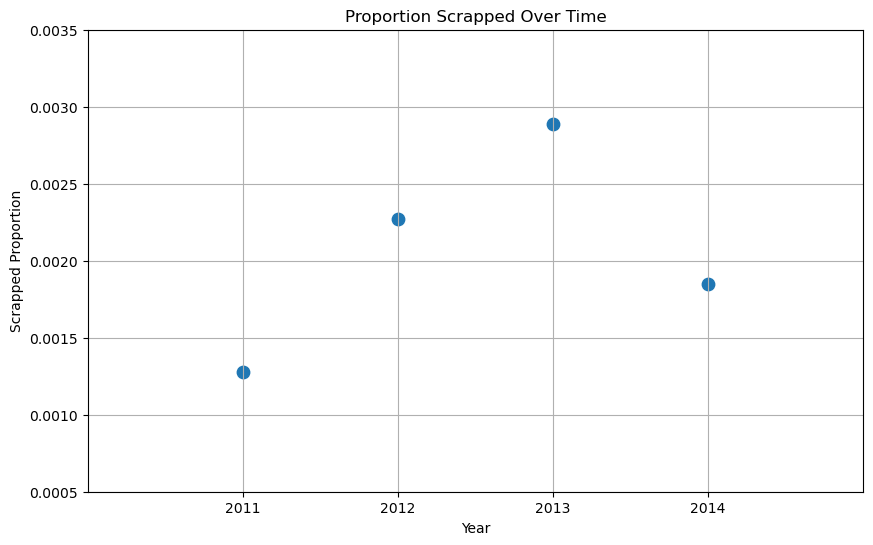

In [46]:
x = df_ScrappedProductsPerYear['ScrapYear']
y = df_ScrappedProductsPerYear['ProportionScrapped']

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(x, y, s=80)
ax.set(ylim=(0.0005, 0.0035))
ax.set(xlim=(2010, 2015), xticks=(2011, 2012, 2013, 2014))
ax.set_xlabel('Year')
ax.set_ylabel('Scrapped Proportion')
ax.set_title('Proportion Scrapped Over Time')
ax.grid()

plt.show()